# ESL-LASSO implementation 

In [1]:
using Plots, LinearAlgebra, Random, Distributions, Suppressor, ForwardDiff

## ESL loss and penalization term

- Exponentiasl squared loss with tuning parameter $\gamma$, $\phi_\gamma(t)= 1-  \exp (-t^2/\gamma)$, which leads to the objective function
$$ 1- \frac{1}{n}\sum_{i = 1}^ n \exp \left\{ -(Y_i- x_i^T\beta)^2/\gamma\right\}  . $$
In contrast to the traditional OLS loss, the flatness of this loss function on the tail enables the robust estimates;

- Adaptive LASSO regularizer with tuning parameters $\tau_{nj}$, $$\mathcal{p}_{\lambda_{nj}} = \tau_{nj}|\beta_j|/|\tilde{\beta_j}|,$$ where $\tilde{\beta_j}$ is an pilot robust regression estimator, e.g., MM-estimator, S-estimator, OLS estimator, which should at least be $\sqrt{n}$-consistent to $\beta^*$. The goal of adding such penalty term is to guarantee a **consistent** vairable selection procedure with **orcal property**. In the paper, the initial estimator $\tilde{\beta_j}$ is selected as the MM-estimator.

Therefore, the ESL-LASSO estimator is obtained by minimizing the following ojectibve function 
$$\ell_n(\beta)i= - \frac{1}{n} \sum_{i = 1}^ n \exp \left\{ -(Y_i- x_i^T\beta)^2/\gamma\right\} + \sum_{j = 1}^d \frac{\tau_{nj}}{|\tilde{\beta_j}|} |\beta_j|.$$

The tricky part for the optimization is that the loss function $\phi_\gamma(t)$ is convex but quasi-convex.

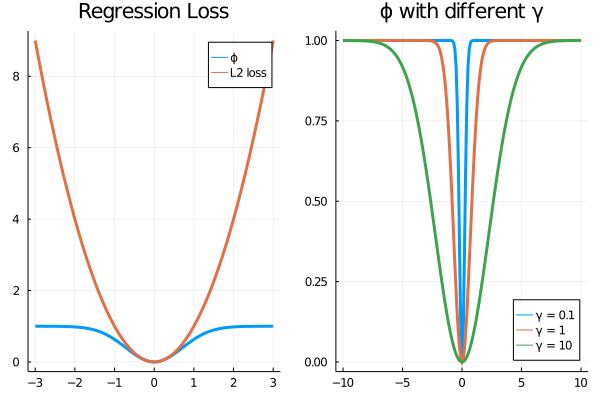

In [2]:
function ϕ(t::Float64, gamma::Float64)
    return 1- exp(- t^2/gamma)
end

# comparison of reg loss function 
x1 = -3: .1:3
y1 = hcat(ϕ.(x1,1.),x1.^2)
p1 = plot(x1, y1, title = "Regression Loss", lw = 3, label = ["ϕ" "L2 loss"])

# effect of gamma in ESL
x = -10: .1:10
y = hcat(ϕ.(x,.1), ϕ.(x,1.),ϕ.(x,10.))
p2 = plot(x, y, title = "ϕ with different γ", lw = 3, label = ["γ = 0.1" "γ = 1"  "γ = 10"], legend = :bottomright)

plot(p1, p2, layout = (1,2))
#savefig("tex/figures/esl.png")

In the above plot(right), we have illustrated the influence of the $\gamma$ to the shape of the ELS loss $\phi_\gamma$. Statistically, the choice of $\gamma$ controls the level of robustness. As shown in the right figure, when $\gamma = 0.1$, the loss is almost invariant to the increase of $|t|$ when $|t| > 1$; while $\gamma = 10$, the loss is sensitive to the change of $|t|$ when $|t|\leq 5$. The design of this loss aligns with the intuition that outliers tend to produce abnormally large residual value and a robust model should not be stable these large residual, meaning that the loss function should be relatively flat in the range of large value. And the value of $\gamma$ corresponds to width of this ra|nge.

In [3]:
# esl empirical loss(l*)
function ESL(beta::Vector,dat::Array{Float64, 2}, gamma::Float64)
    n =size(dat)[1]
    X = dat[:,2:end]
    Y = dat[:,1]
    res = Y - X*beta
    Loss = sum( ϕ.(res, gamma))/n
    return Loss
end 

# adaptive lasso penalty
function adaLASSO(beta::Vector, lambda::Vector)
    return lambda'* abs.(beta)
end

# the objective function 
function ℓ(beta::Vector,dat::Array{Float64, 2}, gamma::Float64, lambda::Vector)
    return ESL(beta, dat, gamma) + adaLASSO(beta, lambda)
end

ℓ (generic function with 1 method)

## Computation

### 1. Dealing with the non-convex loss

#### 1.1. Quadratic approximation (paper)
In the paper, due to the non-convexity of the ESL loss function, for the sake of the computation, the authors consider a quadratic approximation to the loss function at the intial estimator $\tilde{\beta}$. Let 
$$\ell^*(\beta) =  -\frac{1}{n}\sum_{i = 1}^ n \exp \left\{ -(Y_i- x_i^T\beta)^2/\gamma\right\},$$ 
then the actual objevtive function for computation becomes 
$$\tilde{\ell}(\beta) = \frac{1}{2} (\beta - \tilde{\beta})^T \nabla^2 \ell^*(\tilde{\beta}) (\beta - \tilde{\beta}) + \sum_{j = 1}^d \frac{\tau_{nj}}{|\tilde{\beta_j}|} |\beta_j|.$$
Here $\ell^*, \tilde{\ell}$ actually depends on $n$, but we abuse the notation for convenience by dropping the subscript $n$.   Then there are plenty of efficient algorithms---such as ISTA, LARS, corrdinate descent, ADMM---can be used to solve this type of problem.  

However, there is an obvious flaw of this global convex relaxation strategy---**L2 loss is NOT robust**.  To overcome the influence of outliers, the loss function of a robust regression is usually bounded above (meaning that it has to be non-convex), in which case the the outliers cannot leverage the estimates arbitrarily. Therefore, the main concern of this global quadratic appriximation is that the squared loss can potentially ruin the robustness of the estimates. Such quadrtic approximation is  acceptable **only when the initial estimator $\tilde{\beta}$ is close to the optimum**. As displayed in the left figure above, the ESL can be approximated well by quadratic function around $0$.

#### 1.2. Proximal gradient algorithm (We proposed)

We propose an simple iterative algorithm of solving this $L_1$ penalized optimization problem, 
$$\beta_{k+1} \gets \text{Prox}_{\alpha_k, \mathcal{P}}(\beta_k - \alpha_k \nabla \ell_n^*(\beta_k)), \quad \alpha_k \leq \left(\frac{2}{\gamma} \sigma_1\left(\frac{1}{n} \sum_{i=1}^n x_i x_i^T \right)\right)^{-1}, $$
where $ \text{Prox}_{\alpha_k, \mathcal{P}}(\cdot)$ is the proximal operator and $\mathcal{P}(\beta) = \sum_{j = 1}^d \frac{\tau_{nj}}{|\tilde{\beta_j}|} |\beta_j|$. This simple algorithm is designed by using the idea of the majorization-maximization method---by optimizing a sequence of quadratic upper bounds of the target function and decreasing the objective value at each step (the detailed interpretation of this algorithm will be included in the qualify report). 

- The prox can be written as the **soft-thresholding operator**: Let $\beta^+_k := \beta_k - \alpha_k  \nabla \ell_n^*(\beta_k) $, $\lambda_j = \frac{\tau_{nj}}{|\tilde{\beta_j}|}$,
$$\left[\text{Prox}_{\alpha_k, \mathcal{P}} (\beta^+_k) \right]_j= \left[S_{\lambda_j\alpha_k }(\beta^+_k)\right]_{j}=\left\{\begin{array}{ll}
\left[ \beta^+_k\right]_j-\lambda_j\alpha_k & \text { if } \left[ \beta^+_k\right]_j>\lambda \\
0 & \text { if }-\lambda_j\alpha_k  \leq \left[ \beta^+_k\right]_j \leq \lambda_j\alpha_k , \quad i=1, \ldots, d \\
\left[ \beta^+_k\right]_j+\lambda_j\alpha_k  & \text { if } \left[ \beta^+_k\right]_j<-\lambda
\end{array}\right.$$
The implementation of this is simple and can be very efficient with broadcasting.

Write $ \ell_i^*(\beta) = 1- \exp \left\{ -(Y_i- x_i^T\beta)^2/\gamma\right\}$ and hence $\ell^* = \frac{1}{n}\sum_{i=1}^n \ell_i^*$. We can examine the gradient and Hessian as follows.
- The grad: 
$$\nabla \ell_i^*(\beta) = \frac{2 r_i(\beta)}{\gamma}\exp\left(-\frac{2 r_i(\beta)^2}{\gamma} \right) x_i,$$
where $r_i(\beta) = x_i^T\beta - y_i$.
- The Hessian:
$$\begin{aligned}
\nabla^2 \ell_i^*(\beta) & = \frac{2}{\gamma} \left[ \exp\left(-\frac{2 r_i(\beta)^2}{\gamma} \right) \left(1- \frac{2 r_i(\beta)^2}{\gamma} \right)\right] (x_i x_i^T) \\
& \preceq \frac{2}{\gamma} (x_i x_i^T)
\end{aligned}.$$
This upper bound determines the Lipshitz constant for the grad of $\ell^*$ and we can use the L-smoothness of $\ell^*$ to construct a tight quadratic upper bounds for it.

In [4]:
# soft-thresholding operator
function sfth(beta::Array{Float64,1}, lambda::Array{Float64,1})
    a = max.(abs.(beta) - lambda, 0 )
    return a.* sign.(beta)
end

# proximalGD algorithm of solving l1 penalized obj
function proxGD(x0::Array{Float64,1}, obj::Function, grd::Function, lrt::Function, sfth::Function, lambda::Array{Float64,1}, num_iters::Int = 100000)
    x = x0
    for i = 1:num_iters
        xx = x - lrt(i).* grd(x)
        x = sfth(xx, lrt(i)*lambda)
        if i%10000 == 0
            println(x,"\r")
        end
    end
    return x, obj(x)
end

# true grad of l*
function ∇ESL( beta::Vector,dat::Array{Float64, 2}, gamma::Float64)
    X = dat[:, 2:end]
    Y = dat[:,1]
    n = size(dat)[1]
    res = X*beta - Y
    D = (res/gamma) .* exp.(-res.^2/gamma) .* X
    return  2 * mean(D, dims  = 1)[1,:]
end    
# we can also use ForwardDiff (autograd), which is equivalent

∇ESL (generic function with 1 method)

In [25]:
#1d synthetic dataset
Random.seed!(2021)
n1 = 200
X = randn(n1,1)
Y = 30*X + randn(n1,1) .+ 3
dat = hcat(Y,X)
λ =[log(20.)/20] #logn/n  
γ = .3
#grd and obj
esl = x -> ESL(x, dat, γ)
esl_grd = x-> ∇ESL(x, dat, γ)
esl_autogrd = x-> ForwardDiff.gradient(esl, x)
obj = x-> ℓ(x, dat, γ, λ)

#109 (generic function with 1 method)

Note that because of the non-convexity nature of this optimization problem, there is no global convergence guarantee on the proximal GD algorithm. In fact, we illustrate below to show that this algorithm will stuck at some place.

[0.0]
[0.0]
[0.0]
[0.0]
[0.0]
[0.0]
[0.0]
[0.0]
[0.0]
[0.0]


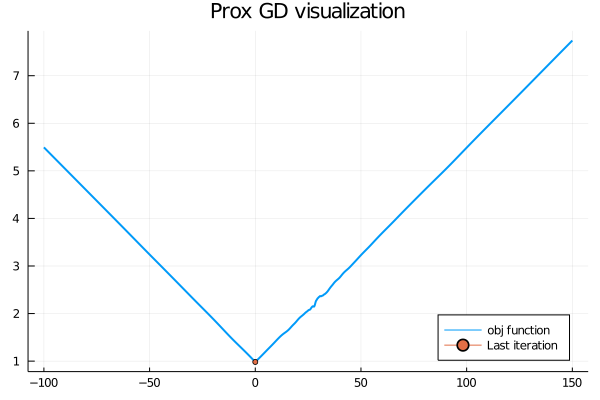

In [27]:
#plot the objective function
xx= -100:.1:150
yy= [[i] for i in xx]
plot(xx, obj.(yy),lw = 2, title = "Prox GD visualization", label = "obj function")
# check the conv of proxGD
lrt = i-> .1 # step length
a,b = proxGD([100.], obj, esl_grd, lrt, sfth, λ)
plot!(a, [b], mark = 3, label = "Last iteration",  legend = :bottomright)
# plot!(xx, 100 .*(esl.(yy).-0.8), lw  = 2,label = "esl loss", title = "ESL empirical loss")

### 2. Tuning parameter selection

#### 2.1. $\tau_{nj}$ in the penalty term

The choice of $\tau_{nj}$ is simply proposed as $\tau_{nj} = \log(n)/n$, which ensures the oracal property for the variable selection. For notational convenience, we drop the index $j$ by writing $\tau_n = \log(n)$ for the rest of document. 


#### 2.2. $\gamma$ in the loss function

**The influence of $\gamma$ to the optimization**

The selection of $\gamma$ is crucial in terms of robustness. In previous section, we find that the change of $\gamma$ leads to a drastic variation of the optimization land scape f the ESL--- larger $\gamma$ leads to a smoother $\ell^*$ , where $\ell^*$ is the empirical ESL loss without regularizer. The following figures displayes the shape of $\ell^*$ under different $\gamma$ with the previous simulated data. 


In [7]:
plt = plot( xlim = (-100, 150), title = "ℓ* under different γ")
xx= -100:.1:150
yy= [[i] for i in xx]

for γ = [1. 5. 20.]
    esl = x -> ESL(x, dat, γ)
    plot!( xx, esl.(yy),lw = 3, label = "γ = $γ", legend = :bottomleft)
end 

#savefig("tex/figures/lstar.png")

**How to select $\gamma$**

The author propose a data-dependent procedure to **learn** the valule of $\gamma$, which includes three steps:
1. Find pseudo outliers $D_m$;

2. Learn $\gamma$ by optimizing the **determinant of the asymptotic covariance matrix** of $\hat{\beta}_n$---$\hat{V}(\gamma)=\left\{\hat{I}_{1}\left(\hat{\boldsymbol{\beta}}_{n}\right)\right\}^{-1} \tilde{\Sigma}_{2}\left\{\hat{I}_{1}\left(\hat{\boldsymbol{\beta}}_{n}\right)\right\}^{-1}$---within the range 
$$G = \left\{\gamma: \frac{2m}{n} + \frac{2}{n}\sum_{ i =m+ 1}^n \phi_\gamma(r_i(\beta_n))\leq 1\right\}, $$ where
$$ \begin{aligned}
\hat{I}_{1}\left(\hat{\boldsymbol{\beta}}_{n}\right) &=\frac{2}{\gamma}\left\{\frac{1}{n} \sum_{i=1}^{n} \exp \left(-r_{i}^{2}\left(\hat{\boldsymbol{\beta}}_{n}\right) / \gamma\right)\left(\frac{2 r_{i}^{2}\left(\hat{\boldsymbol{\beta}}_{n}\right)}{\gamma}-1\right)\right\}\left(\frac{1}{n} \sum_{i=1}^{n} \mathbf{x}_{i} \mathbf{x}_{i}^{T}\right) \\
\tilde{\Sigma}_{2} &=\operatorname{cov}\left\{\exp \left(-r_{1}^{2}\left(\hat{\boldsymbol{\beta}}_{n}\right) / \gamma\right) \frac{2 r_{1}\left(\hat{\boldsymbol{\beta}}_{n}\right)}{\gamma} \mathbf{x}_{1}, \cdots, \exp \left(-r_{n}^{2}\left(\hat{\boldsymbol{\beta}}_{n}\right) / \gamma\right) \frac{2 r_{n}\left(\hat{\boldsymbol{\beta}}_{n}\right)}{\gamma} \mathbf{x}_{n}\right\}
\end{aligned}.$$
 The key notice here is that in step 2, the target under minimization **depends on the value of** $\beta_n$. 

3. Update $\beta_n$ by optimizing the objective function (using proximal GD algorithm presented above) with $\tau_j = \log(n)/n$ and $\gamma$ obtained in step 2.

Repeat Steps 1-3 until $\beta_n$ and $\gamma$ converge. The intial value of $\beta_n$ is chosen as the MM-estimator $\tilde{\beta_n}$, which is used in the adaptive LASSO penelty. The key design of this procedure is the Step 2, where the choice of $\gamma$ aims to endow $\beta_n$  with the orcal property (by minimizing the asymptotic cov) and high breakdown point (by searching $\gamma$ within **some range**).
  

However, there is no smart algorithm that efficiently solves the constrained optimization problem in Step2.  In fact, as described in the paper, the way of finding the $\gamma$ in Step 2 is literally done by grid search (see their Figure 1). It is acceptable in practice since it is a 1-d optimization problem and the complexity of evaluating the function is $O(d^3)$ (involving a matrix inverse).

In [8]:
######################################
#####functions for step 2#############
######################################


# find pseudo outlier
function find_pseudo_out(beta::Vector,dat::Array{Float64, 2})
    X = dat[:, 2:end]
    Y = dat[:,1]
    n = size(dat)[1]
    res = X*beta - Y
    Sn = 1.4826 * median( abs.(res .- median(res)))
    ind = findall(x-> abs(x)≥ 2.5Sn, res)
    D_out = dat[ind, 1:end]
    D_good = dat[1:end .∉ [ind], 1:end]
    return D_out, D_good 
end

# use logdet for numerical stability
function logdet_V( beta::Vector,dat::Array{Float64, 2}, gamma::Float64)
    X = dat[:, 2:end]
    Y = dat[:,1]
    n = size(dat)[1]
    res = X*beta - Y
    #I^{-1}
    a = 2/gamma * mean(exp.(-res.^2/gamma).*(2*res.^2/gamma.-1))
    cov_x = X'*X/n
    inv_I = inv(cov_x)/a
    #Σ
    D = (2res/gamma) .* exp.(-res.^2/gamma) .* X
    st_D = D .- mean(D, dims = 1)
    Σ = st_D'*st_D/n
    return logdet(inv_I*Σ*inv_I)
end

#find range G
function ξ( beta::Vector,dat_good::Array{Float64, 2}, gamma::Float64, n)
    m = n - size(dat_good)[1]
    return 2m/n + 2/n*(n-m)*ESL(beta, dat_good, gamma)
end

function get_G(beta::Vector,dat_good::Array{Float64, 2}, gm::Vector, n)
    xxi = gm -> ξ(beta,dat_good, gm, n) 
    ξ_val = xxi.(gm)
    ind = findall(x -> x ≤ 1, ξ_val)
    G = gm[ind]
    return G, ξ_val[ind]
end

# find the optimal gamma
function search_gamma(beta::Vector, dat::Array{Float64, 2}, γ_seq::Vector) 
    n = size(dat)[1]
    _ ,dat_good = find_pseudo_out(beta, dat)  #find pseudo outliers
    xxi = gm -> ξ(beta,dat_good, gm, n)
    G, _ = get_G(beta, dat_good, γ_seq, n) # find G 
    dv = gm -> logdet_V(beta,dat, gm)
    gamma_opt = G[argmin(dv.(G))]  #find optimal γ
    return gamma_opt
end


# making plots for the G and optimal gamma
function gamma_plot(beta::Vector, dat::Array{Float64, 2}, gm::Vector)
     n = size(dat)[1]
    _ ,dat_good = find_pseudo_out(beta, dat)  #find pseudo outliers
    
    #p1 plot G and ξ val
    xxi = gm -> ξ(beta,dat_good, gm, n)
    p1 = plot(gm, xxi.(gm), ylim =(0,1.2) , lw = 3, xlabel = "γ", ylabel= "ξ(γ)" , title  = "Find G", label = "")
    G, xi = get_G(beta, dat_good, Array(gm), n) # find G and corresponding ξ values
    plot!(G, xi, lw=3, label = " G")
    
    #p2 plot logdev and opt γ    
    dv = gm -> logdet_V(beta,dat, gm ) 
    p2 = plot(gm, dv.(gm), lw = 3, xlabel= "γ", ylabel= "logdet(V(γ))", title = "Find γ",label = "")
    gamma_opt = search_gamma(beta, dat, gm)  #find optimal γ
    plot!([gamma_opt], [minimum(dv.(gm))], mark = 5, label = "optimal γ")
    
    # show the plot
    plot(p1, p2, layout = (1,2))
end

gamma_plot (generic function with 1 method)

The way of finding G and $\gamma$ is just by looking at those plots. The key limitation of Step2 is the automation of the inference procedure---to perform a grid search, we must prespecify a reasonable range, which is obviously problem specific and requires some tuning.   We replicate the Figure 1. of the original paper as follows to illustrate how to find to determine set G and find $\gamma$ in Step 2. we generate a synthetic dataset with $n = 800$, $d= 8$, $\beta  = [1.,1.5, 2.,1.,0.,0.,0.,0. ]$. We generate $(X_i)_{i =1}^n$ i.i.d from a multinormal distribution $\mathcal{N}(0, \Omega_2) $, where $(i,j)$-th element of $\Omega_2$ is $0.5^{|i-j|}$. And $Y_i  = X_i^T \beta + \epsilon$, where $\epsilon\sim \text{Cauchy}(0,1)$.

In [9]:
Random.seed!(202102)
# simulate dataset as in the paper
Omega2 = 0.5.^ (abs.(Array(1:8) .- Array(1:8)'))
# isposdef!(Omega2)
n = 800
L  = cholesky(Omega2)
X =( L.L * randn(8,n))'
beta_true  = [1.,1.5, 2.,1.,0.,0.,0.,0. ]
Y  = X*beta_true + rand(Cauchy(),n) 
Dat = hcat(Y, X)


800×9 Array{Float64,2}:
  6.66663    2.26654    1.76371    …   0.732585    0.0533183  -0.628258
  3.17446   -0.568045  -0.290432       0.0294616   0.674915   -0.747509
  0.134793   0.923698  -0.0678524     -0.329027    0.138088    0.0111555
  5.41037   -0.824903   0.565764       1.157       1.69248     0.372737
 -1.85427    0.620967  -0.318664       0.827126   -0.901563   -1.35518
  5.16145    0.746819   0.829235   …  -0.0549827  -1.28709    -0.214125
 -4.52562   -0.537082  -0.671303      -0.350171   -0.460876    0.627194
  5.85796    0.86393    0.723557       1.11474     0.448124    1.36133
  7.86234    0.338392   1.59968        0.532641   -0.337809    1.46504
  4.44315    0.212861   1.69755        1.01033    -0.427638   -0.188114
 -3.01251    0.132596  -1.4708     …  -0.969108   -0.382803    0.630117
 -4.57044   -1.6881    -2.29064        0.199812    1.43047     0.559259
 -6.9991    -1.29659   -1.01802        0.380041   -0.360525   -0.571099
  ⋮                                ⋱      

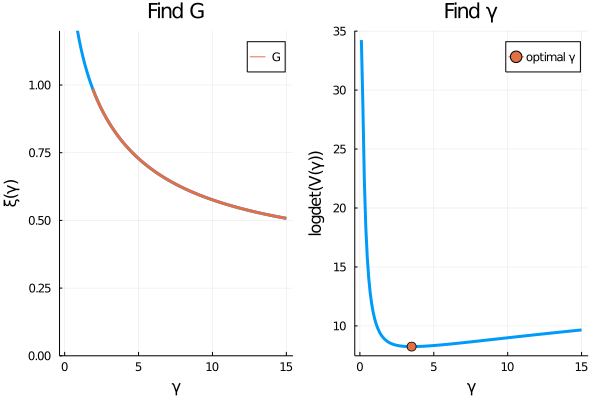

In [10]:
gm = 0.1:0.1:15
gamma_plot(beta_true, Dat,Array(gm))
# savefig("tex/figures/gamma_plot.png")

### Complete inference algorithm 

Now we provide the code for the complete procedure of ESL-LASSO inference, which uses the complicated adaptive optimization techiques to find the crucial parameter $\gamma$.

In [11]:
############################################################
###The complete procedure (proposed by paper)###############
############################################################

function esl_lasso( beta0::Array{Float64,1}, dat::Array{Float64, 2}; γ_seq::Array{Float64,1} = Array(.1:.1:50), opt_lrt::Function = i-> .1, opt_iters::Int = 50000, reps::Int = 2)
    ### x0: init_estimator (e.g. MM_estimator)
    ### dat: dataset s.t. Y = dat[:,1], X = dat[:, 2:end] 
    ### γ_seq: γ values to perform grid search (e.g. .1:.1:20)
    ### opt_alg: proxGD
    ### opt_lrt: smaller than Lipschitz
    ### opt_iters: niter for proxGD
    ### reps: number of reptitions of step1-3
    n =  size(dat)[1]
    X = dat[:,2:end]
    beta = beta0
    for k = 1:reps 
        # find the optimal gamma
        gamma_opt = search_gamma(beta, dat, γ_seq)
        println("γ = $gamma_opt")
        #adaLASSO parameter
        lambda = (log(n)/n)./ (abs.(beta) .+ 1e-10)  
        
        # update beta using proxGD
        obj = b-> ℓ(b, dat, gamma_opt, lambda)
        esl_grd = b-> ∇ESL(b, dat, gamma_opt)
        lip_cont = abs(eigmax(X'*X/n)*2/gamma_opt)
        lrt = i-> min(opt_lrt(i), lip_cont)
        beta, _ = proxGD(beta, obj, esl_grd, lrt, sfth, lambda, opt_iters)
    end
        
    return beta
end


esl_lasso (generic function with 1 method)

Below we perform a complete ESL-LASSO inference procedure for the previous synthetic dataset with initial estimates chosen as the MM-estimator. As suggested in the paper, we only repeat the Step1-3 once and the estimates produced is quite close to the true one. In general, with large sample size (around 1000), the ESL-LASSO inference procedure provides prretty accurate estimates. However,  as we try different number of repetitions of Step1-3, we find some issue. 


In [12]:
# performing esl_lasso inference with above simulated dataset 
# beta_true  = [1.,1.5, 2.,1.,0.,0.,0.,0. ]
opt_lrt = i-> .1
#MM estimator (computed from R)
MM = [1.013508 ,1.483255 ,2.052222, 1.009798, -0.07373979 ,-0.09211071 ,-0.00702801 ,-0.01657055]
esl_lasso(MM, Dat)

γ = 3.8
[0.9977869453659487, 1.6104736028691897, 1.9765504278147588, 0.8509747847377364, -0.0, -0.0, -0.0, 0.0]
[0.9977869453659487, 1.6104736028691897, 1.9765504278147588, 0.8509747847377364, -0.0, -0.0, -0.0, 0.0]
[0.9977869453659487, 1.6104736028691897, 1.9765504278147588, 0.8509747847377364, -0.0, -0.0, -0.0, 0.0]
[0.9977869453659487, 1.6104736028691897, 1.9765504278147588, 0.8509747847377364, -0.0, -0.0, -0.0, 0.0]
[0.9977869453659487, 1.6104736028691897, 1.9765504278147588, 0.8509747847377364, -0.0, -0.0, -0.0, 0.0]
γ = 3.3
[0.9988964837673584, 1.6151806221044158, 1.9769381285595293, 0.8418929498041625, -0.0, -0.0, -0.0, 0.0]
[0.9988964837673584, 1.6151806221044158, 1.9769381285595293, 0.8418929498041625, -0.0, -0.0, -0.0, 0.0]
[0.9988964837673584, 1.6151806221044158, 1.9769381285595293, 0.8418929498041625, -0.0, -0.0, -0.0, 0.0]
[0.9988964837673584, 1.6151806221044158, 1.9769381285595293, 0.8418929498041625, -0.0, -0.0, -0.0, 0.0]
[0.9988964837673584, 1.6151806221044158, 1.97693

8-element Array{Float64,1}:
  0.9988964837673584
  1.6151806221044158
  1.9769381285595293
  0.8418929498041625
 -0.0
 -0.0
 -0.0
  0.0

With the same datasets and initial value, we perform ESL-LASSO inferece again by repeating Step1-3 6 times. As described in the paper, by keep iterating Step1-3, eventually $\gamma$ and $\hat{\beta}_n$ will converge together. However, as shown in the follwoing outputs, the choice of $\gamma$ and the estiamtes $\hat{\beta}_n$ diverge to some wild value, yielding to nonsense estimates. This issue can be reproduced on different datasets and initial values---increasing the repetition of Step1-3 tends to produce worse estimates, especially when the sample size is small.  However, we do find out that with very large sample size (n = 1999), repeating Step1-3 can still maintain accurate estimates, but repeating Step1-3 seems to be useless in this case since the estimates obtianed in the first round is already accurate. 

In [13]:
# repeat Step1-3 5 times
esl_lasso(MM, Dat;reps =  6) 

γ = 3.8
[0.9977869453659487, 1.6104736028691897, 1.9765504278147588, 0.8509747847377364, -0.0, -0.0, -0.0, 0.0]
[0.9977869453659487, 1.6104736028691897, 1.9765504278147588, 0.8509747847377364, -0.0, -0.0, -0.0, 0.0]
[0.9977869453659487, 1.6104736028691897, 1.9765504278147588, 0.8509747847377364, -0.0, -0.0, -0.0, 0.0]
[0.9977869453659487, 1.6104736028691897, 1.9765504278147588, 0.8509747847377364, -0.0, -0.0, -0.0, 0.0]
[0.9977869453659487, 1.6104736028691897, 1.9765504278147588, 0.8509747847377364, -0.0, -0.0, -0.0, 0.0]
γ = 3.3
[0.9988964837673584, 1.6151806221044158, 1.9769381285595293, 0.8418929498041625, -0.0, -0.0, -0.0, 0.0]
[0.9988964837673584, 1.6151806221044158, 1.9769381285595293, 0.8418929498041625, -0.0, -0.0, -0.0, 0.0]
[0.9988964837673584, 1.6151806221044158, 1.9769381285595293, 0.8418929498041625, -0.0, -0.0, -0.0, 0.0]
[0.9988964837673584, 1.6151806221044158, 1.9769381285595293, 0.8418929498041625, -0.0, -0.0, -0.0, 0.0]
[0.9988964837673584, 1.6151806221044158, 1.97693

8-element Array{Float64,1}:
  0.9988331622354776
  1.61534877154021
  1.9773279583507406
  0.8410253940309074
 -0.0
 -0.0
 -0.0
  0.0

Remarks:  After I conduced the full simulation study, the performance of this ESL_LASSO is **shockingly bad**. In fact, there is no hope to reproduce their simulation results and the proposed methods cannot handle the outlier at all. Given that I did not follow the steps described in the paper explicitly (e.g., global quadratic approximation, coordinate descent optimization) though, I could not speculate how they obtain the experiment, the proposed method as good as what claimed in the paper. To be more specific, the key problem of their method is the selection of the $\gamma$. For the first two simulation datasets described in the paper, the $\gamma$ selected was abnormlaly large and the resulting estimator is just all $0$. For the third datasets, the variable selection seems to be consistent but the estimator is accurate, even when the sample size gets large (over $1000$) where PENSE performs really well. 

To illustrate and diagnose the problme of the $\gamma$ selection, I will include some plots in the final report.

To recover their method, I came up with my own idea of selecting the partameter $\gamma$, which is able to signficantly boost the performance of ESL_LASSO and is also much more reliable in contrast to the original method. The detailed procedure is desribed in the next section.

### New procedure of choosing $\gamma$ 

The intuition of our method is from the expression of the loss function
$$ 1- \frac{1}{n}\sum_{i = 1}^ n \exp \left\{ -(Y_i- x_i^T\beta)^2/\gamma\right\}  ,$$
where the $\gamma$ serves as a scale parameter that controls the importance of the residual error. Therefore, a naive idea is to use the estimated variance of the residual. However, considering the presence of outliers, estimating the residual vairance with the raw datset is not appropriate since the outlier can introduce a huge influence to the sample variance, leading to an overestimation. Thus, our goal is find a relatively robust variance estimator. 

The Step 1 (detecting pseudo outliers) of the original paper inspires us that we can first use this step to discard the potential outliers from the original dataset, and estimate the residual variance use the " washed" dataset. The detailed steps are described below:

1'. Find pseudo outliers $D_m$ and the "washed" dataset $D_{n\setminus m}$;

2'. $\gamma \gets \frac{1}{n-m} \sum_{i = m+1}^n ( Y_i - X_i \beta )^2$.

3'. Obtain $\hat \beta$ by solving ESL-LASSO with proximal GD algorithm.

Note that Step2' also depend on the current estimates of $\beta$. For the initial round, we use the initial value of $\beta$ (MM-estimator) in Step 2' and then repeat Step1'-3' until convergence. In practice, we find that the value of $\gamma$ and $\beta$ do not vary much across different rounds, so we propose to just repeat Step1'-2' once. 

In [14]:
#########################################################
###The complete procedure (proposed by us)###############
#########################################################

function our_esl_lasso(beta0::Array{Float64,1}, dat::Array{Float64, 2}; opt_lrt::Function = i-> .1, opt_iters::Int = 50000, reps::Int = 2)
    n =  size(dat)[1]
    X = dat[:,2:end]
    beta = beta0
    
    for k  = 1:reps
        # find pseudo outlier 
        _, dat_good = find_pseudo_out(beta::Vector,dat::Array{Float64, 2})
        
        # use the residual variance of "washed" dataset as gamma 
        gamma =sum((dat_good[:,1] - dat_good[:,2:end]*beta).^2)/size(dat_good)[1]
        println("γ = $gamma")
        
        #adaLASSO parameter
        lambda = (log(n)/n)./ (abs.(beta) .+ 1e-10)  
        
        # update beta using proxGD
        obj = b-> ℓ(b, dat, gamma, lambda)
        esl_grd = b-> ∇ESL(b, dat, gamma)
        lip_cont = abs(eigmax(X'*X/n)*2/gamma)
        lrt = i-> min(opt_lrt(i), lip_cont)
        beta, _ = proxGD(beta, obj, esl_grd, lrt, sfth, lambda, opt_iters)
    end

    return beta
end


our_esl_lasso (generic function with 1 method)

Finally, we perform our version of ESL_LASSO on the same synthetic dataset, and compare with the paper version of ESL_LASSO. Note that the true coefficients is given by $\beta  = [1.,1.5, 2.,1.,0.,0.,0.,0. ]$, by simply looking at the following outputs, we conclude that our modification is succsessful.

In [15]:
our_esl_lasso(MM, Dat;reps = 6)

γ = 1.9723628353858573
[1.0053791844171298, 1.6126674426234946, 1.9626192763295387, 0.8576626841872692, -0.0, -0.0, -0.0, 0.0]
[1.0053791844171298, 1.6126674426234946, 1.9626192763295387, 0.8576626841872692, -0.0, -0.0, -0.0, 0.0]
[1.0053791844171298, 1.6126674426234946, 1.9626192763295387, 0.8576626841872692, -0.0, -0.0, -0.0, 0.0]
[1.0053791844171298, 1.6126674426234946, 1.9626192763295387, 0.8576626841872692, -0.0, -0.0, -0.0, 0.0]
[1.0053791844171298, 1.6126674426234946, 1.9626192763295387, 0.8576626841872692, -0.0, -0.0, -0.0, 0.0]
γ = 1.954794471286978
[1.0030704680253917, 1.617114833872204, 1.9648135917459186, 0.84866166875117, -0.0, -0.0, -0.0, 0.0]
[1.0030704680253917, 1.617114833872204, 1.9648135917459186, 0.84866166875117, -0.0, -0.0, -0.0, 0.0]
[1.0030704680253917, 1.617114833872204, 1.9648135917459186, 0.84866166875117, -0.0, -0.0, -0.0, 0.0]
[1.0030704680253917, 1.617114833872204, 1.9648135917459186, 0.84866166875117, -0.0, -0.0, -0.0, 0.0]
[1.0030704680253917, 1.61711483

8-element Array{Float64,1}:
  1.0028787759898872
  1.6173226987279188
  1.9651620637704577
  0.8479086889134222
 -0.0
 -0.0
 -0.0
  0.0